In [1]:
%matplotlib widget

import pickle
import numpy as np
from pacti.terms.polyhedra import PolyhedralContract
from matplotlib.figure import Figure
from matplotlib.backends.backend_pdf import PdfPages
from typing import Tuple
from contract_utils import check_tuple, Schedule
from plot_utils import plot_steps

This notebook demonstrates the visualization of a few schedulable combinations of the 20-step scenarios variants for the operational requirement variants.

In [2]:
f20 = open('results20.data', 'rb')
results20 = pickle.load(f20)
f20.close()

print(f"Failure results: {len(results20[0])}")
print(f"Successful results: {len(results20[1])}")

Failure results: 59390
Successful results: 610


We focus on showing the range of possible values for the battery state-of-charge at each step in the scenario. We also show the uncertainties associated with each step function across all 3 viewpoints: power, science and communication, and navigation. The operational requirements specify constraints on initial conditions and lower bounds at each step. Finally, we also compute the average batter state-of-charge as a figure of merit computed as a min/max optimization. 

In [3]:
def showRange(name: str, range: Tuple[float, float]) -> str:
    return f"{name}=[{range[0]:.3g},{range[1]:.3g}]\n"

def plot_results20(index:int, var:str) -> Figure:
    schedule: Schedule = results20[1][index]
    ranges = schedule.scenario
    dsn_cons = ranges[0]
    chrg_gen = ranges[1]
    sbo_cons = ranges[2]
    tcmh_cons = ranges[3]
    tcmdv_cons = ranges[4]
    dsn_speed = ranges[5]
    sbo_gen = ranges[6]
    dsn_noise = ranges[7]
    chrg_noise = ranges[8]
    sbo_imp = ranges[9]
    tcm_dv_noise = ranges[10]
    tcm_dv_progress = ranges[11]

    op_reqs: np.ndarray = schedule.reqs
    c: PolyhedralContract = schedule.contract
    fsoc = " + ".join([f"0.05 output_soc{i}" for i in range(1, 21)])
    max_soc = c.optimize(fsoc, maximize=True)
    if max_soc is None:
        max_soc = -1

    min_soc = c.optimize(fsoc, maximize=False)
    if min_soc is None:
        min_soc = -1

    u_bounds = check_tuple(c.get_variable_bounds("output_u20"))
    r_bounds = check_tuple(c.get_variable_bounds("output_r20"))
    c_bounds = check_tuple(c.get_variable_bounds("output_c20"))

    text = \
        "* Power uncertainties\n" + \
        showRange("        chrg_gen", chrg_gen) + \
        showRange("        dsn_cons", dsn_cons) + \
        showRange("        sbo_cons", sbo_cons) + \
        showRange("       tcmh_cons", tcmh_cons) + \
        showRange("      tcmdv_cons", tcmdv_cons) + \
        "* Science uncertainties\n" + \
        showRange("         sbo_gen", sbo_gen) + \
        showRange("       dsn_speed", dsn_speed) + \
        "* Navigation uncertainties\n" + \
        showRange("         sbo_imp", sbo_imp) + \
        showRange("       dsn_noise", dsn_noise) + \
        showRange("      chrg_noise", chrg_noise) + \
        showRange("    tcm_dv_noise", tcm_dv_noise) + \
        showRange(" tcm_dv_progress", tcm_dv_progress) + \
        "* Initial conditions\n" + \
        f"     battery soc={op_reqs[0]:.3g}\n" + \
        f"    science data={op_reqs[3]:.3g}\n" + \
        f"   traj. est. u.={op_reqs[4]:.3g}\n" + \
        "* Constraints @ each step\n" + \
        f"    min soc exit={op_reqs[1]:.3g}\n" + \
        f"  min time alloc={op_reqs[2]:.3g}\n" + \
        "* Optimization bounds\n" + \
        f"     average soc=[{min_soc:.3g},{max_soc:.3g}]\n" + \
        showRange("   traj. est. u.", u_bounds) + \
        showRange("   rel. progress", r_bounds) + \
        showRange("   total science", c_bounds)
    
    bounds = [check_tuple(c.get_variable_bounds(f"{var}1_entry"))]
    labels=["initial"]
    n=20
    for i in range(1,n):
        bounds += [check_tuple(c.get_variable_bounds(f"output_{var}{i}"))]
        labels+=[f"{i}"]
    bounds += [check_tuple(c.get_variable_bounds(f"output_{var}{n}"))]
    labels+=[f"final"]
    return plot_steps(bounds, labels, ylabel=var, title=f"Possible values of {var} over the sequence", text=text, nth_tick=2)



Here, we focus on showing the first 15 schedulable combinations; information is also available about which operational requirement constraints resulted in a non-schedulable result.

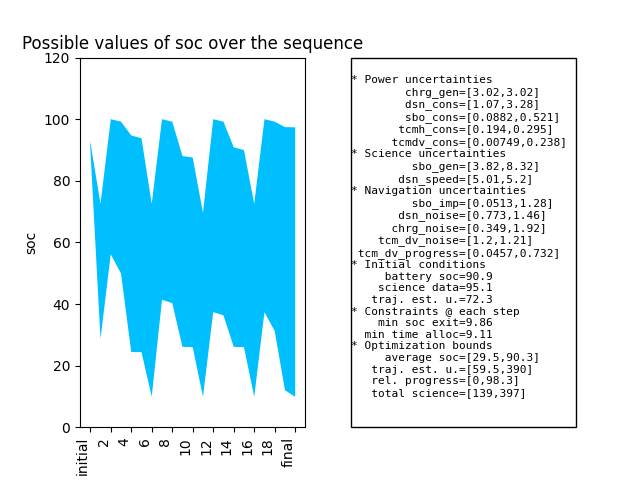

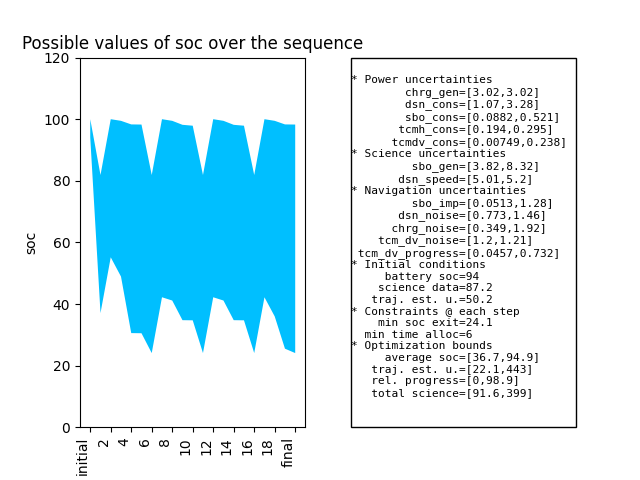

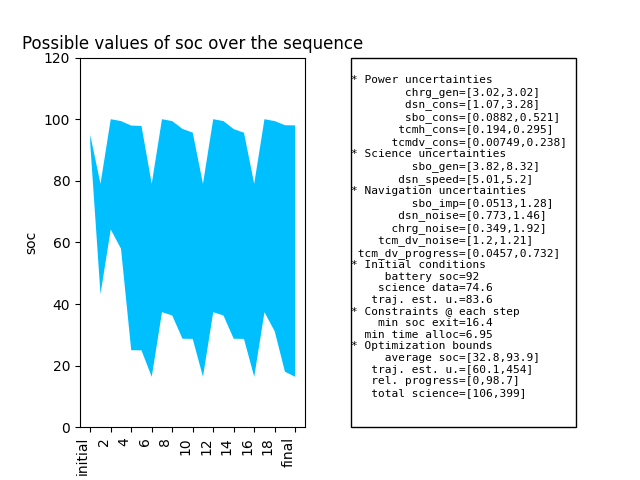

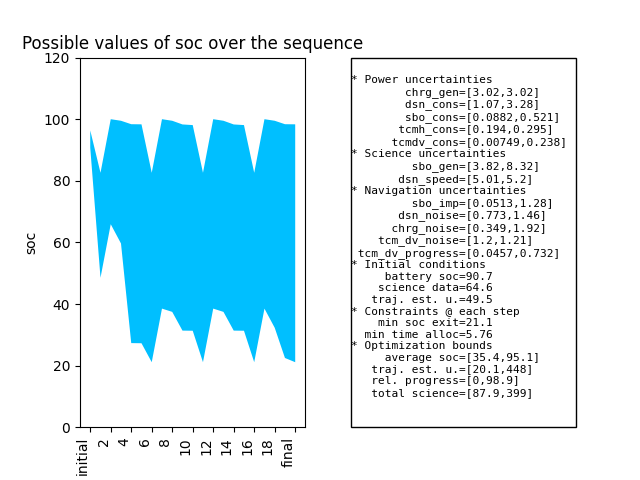

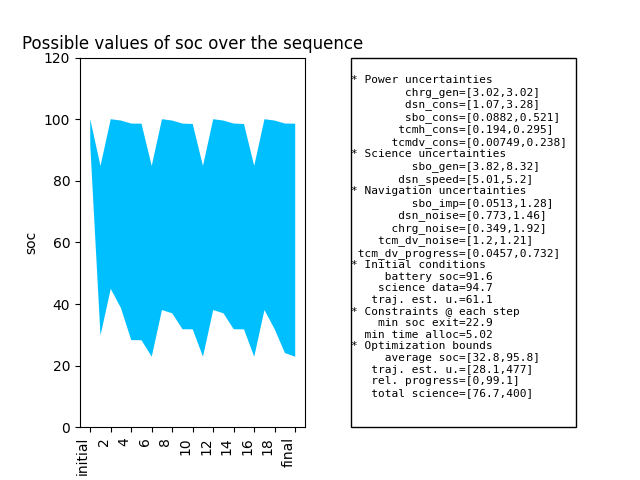

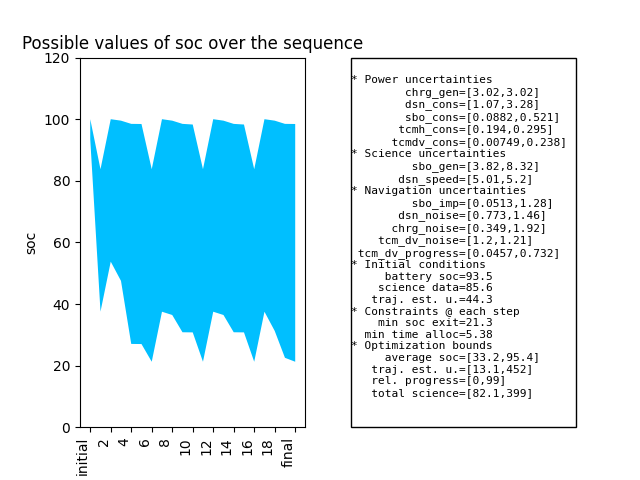

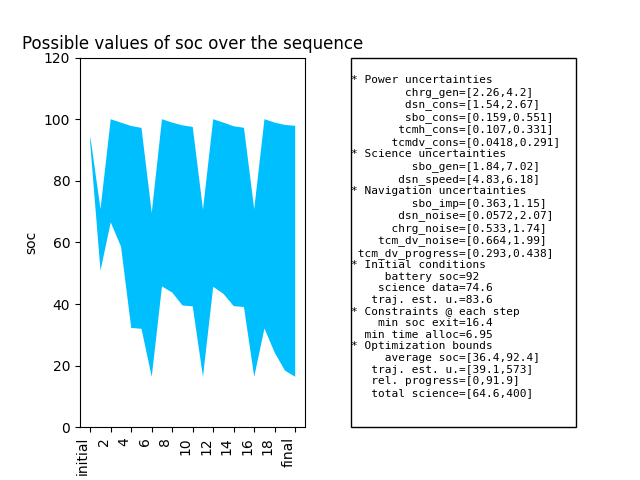

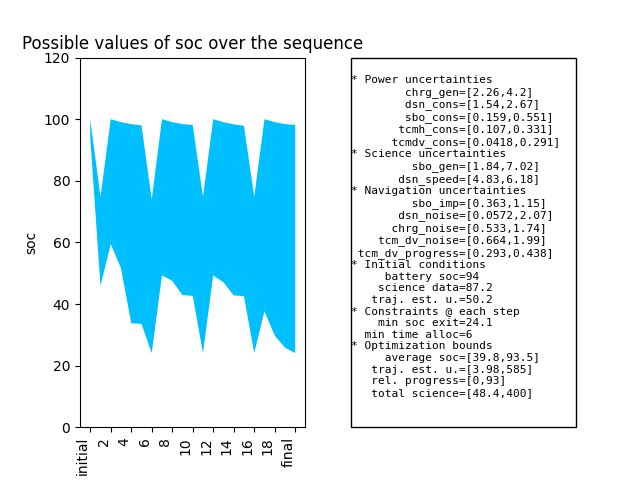

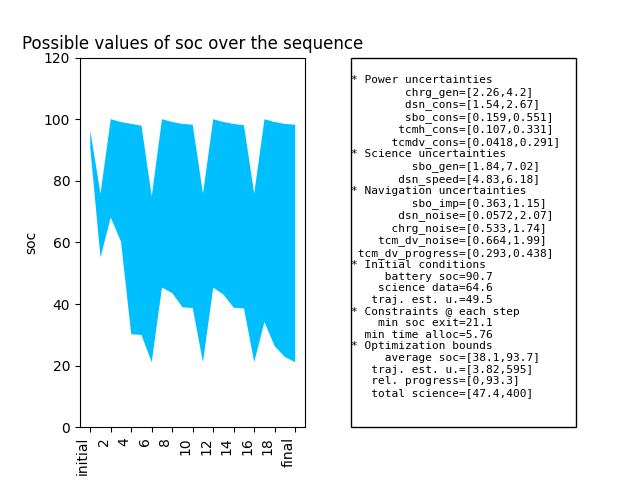

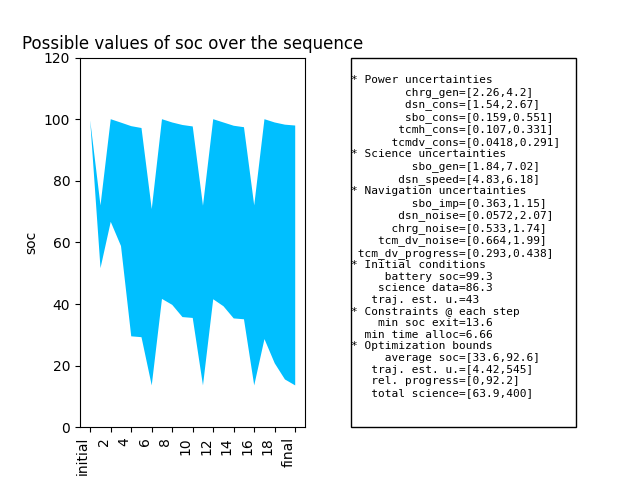

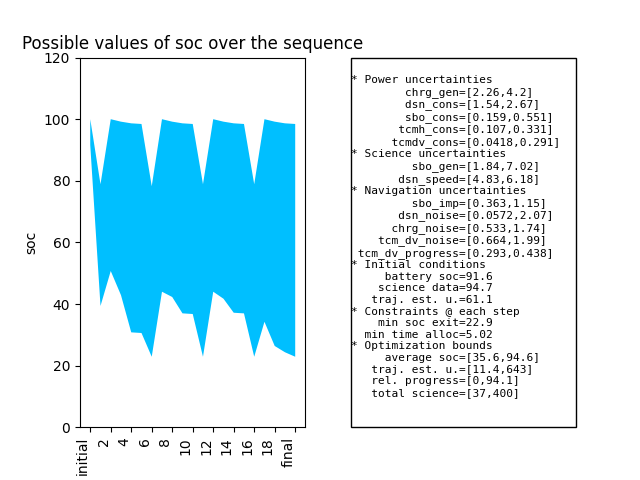

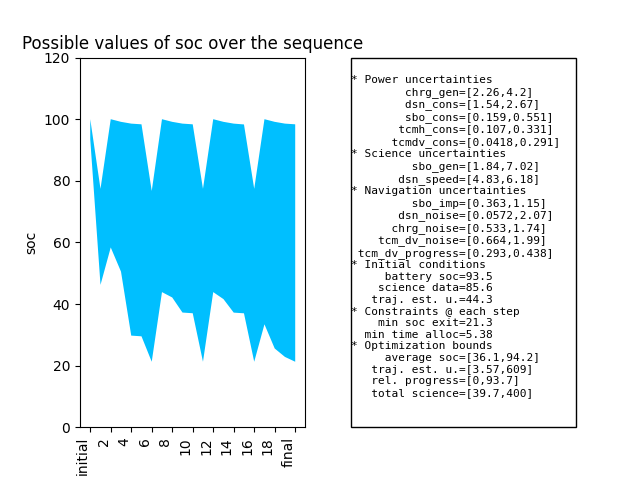

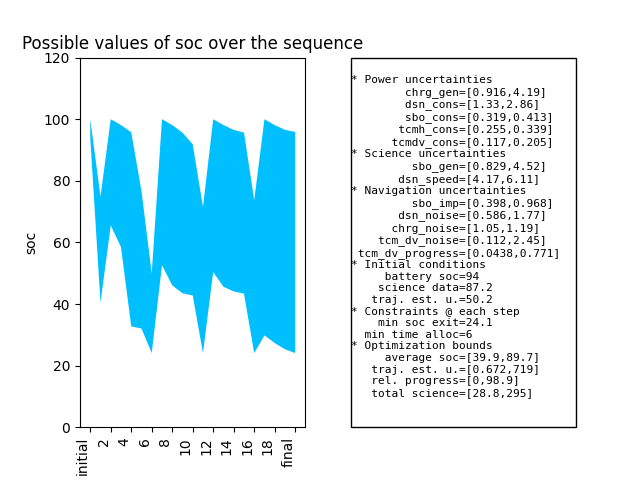

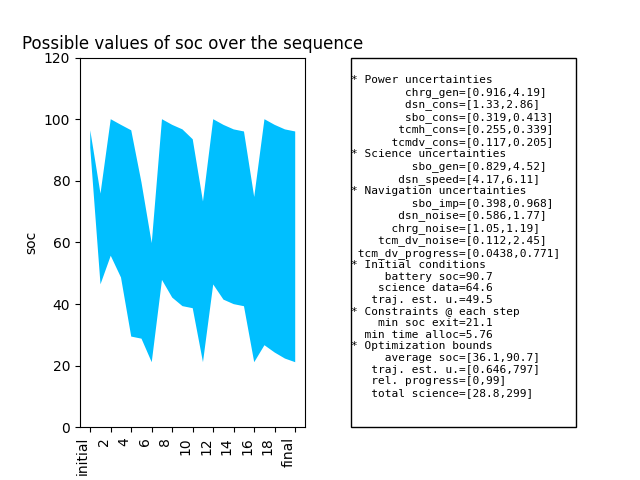

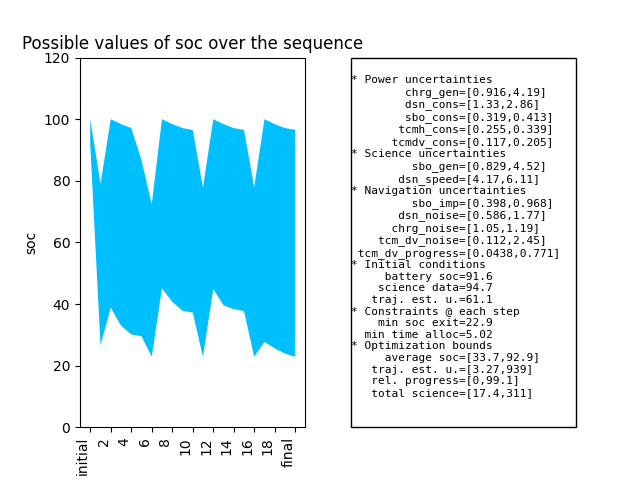

In [4]:
max_fig=15
for i in range(0, min(max_fig,len(results20[1]))):
    pp = PdfPages(f"figures/results20-{i}-soc.pdf")
    fig=plot_results20(index=i, var="soc")
    pp.savefig()
    pp.close()
